In [1]:
import numpy as np
import matplotlib.pyplot as plt
import spiceypy as spy
from urllib import request
import json
from collections import OrderedDict as odict
from astropy.time import Time
from phasteroids import *

In [2]:
spy.furnsh("naif0012.tls")

In [3]:
class BodyJPL:
    
    """ Creates a celestial body as an object,
        using some methods from the Asteroid class"""
    
    def __init__(self, name, bodytype):
        
        """ Given a body name an a bodytype creates an object.
            Parameters:
                name (str): Name of the celestial body
                bodytype (int): Type of the body 
                                planet = 1
                                asteroid = 2
                                others = 3"""
        
        self.name = name
        self.bodytype = bodytype
        if type(bodytype) is not int:
            raise ValueError("Bodytype should be an integer. Planet = 1, Asteroid = 2, Others = 3")
        
    def get_jpl_positions(self,date):
        
        """ Given a date (in UTC format) it downloads from
            the Jet Propulsion Laboratory API the Orbital State
            Vector. 
            Parameter:
                date(str): Date in UTC format.
                
            Returns: 
                np.array([x, y, z, vx, vy, vz]): Orbital State Vector (units = AU, AU/d)"""
        
        if self.bodytype == 1:  
            JPL = Horizons(id=f'{self.name} Barycenter', 
                           location='@sun', 
                           epochs=Time(self.date).jd).vectors()
    
            rt = np.array([JPL[c].value[0] for c in ["x", "y", "z", "vx", "vy", "vz"]])
           
        if self.bodytype == 2:
            html = request.urlopen(f"https://ssd-api.jpl.nasa.gov/sbdb.api?sstr={self.ID}&cov=mat")
            json_data = json.loads(html.read().decode())
            spkid = json_data['object']['spkid']
            JPL = Horizons(id=f'DES={spkid}', 
                           location='@sun', 
                           epochs=Time(self.date).jd).vectors()
    
            rt = np.array([JPL[c].value[0] for c in ["x", "y", "z", "vx", "vy", "vz"]])
     
        if self.bodytype == 3:
            JPL = Horizons(id=f'{self.name}', 
                           location='@sun', 
                           epochs=Time(self.date).jd).vectors()
    
            rt = np.array([JPL[c].value[0] for c in ["x", "y", "z", "vx", "vy", "vz"]])
        
        return rt

In [73]:
class Asteroid(BodyJPL):
    """ Creates an object given an asteroid name.
    
        Parameter: 
            ID (str): Name of the Asteroid in standard notation.
            
        Example: 
            Ast = Asteroid('2008JL3') """
    
    def __init__(self, ID):
        
        """ Once you give an asteroide name, it will take the epoch data 
            from the JPL Small-Body Database as the default date parameter """
        
        self.ID = ID
        if type(ID) is not str:
            raise ValueError(f"ID should be a string, specifically an asteroid name (EX: 2021EU), you passed {self.ID}")
     
        html = request.urlopen(f"https://ssd-api.jpl.nasa.gov/sbdb.api?sstr={self.ID}&cov=mat")
        json_data = json.loads(html.read().decode())
        t0 = float(json_data["orbit"]["epoch"])
        self.epoch = Time(t0, format='jd', scale='utc').iso
        #We assume date equal as epoch
        self.date = self.epoch
        
        
    #GET DATE
    def get_date(self):
        #Para darle utilidad al método es preferible agregarle un return con el formato que el usuario pida
        """ Useful for checking the ephemeris time 
            before calculating the surrogates.
        
            Returns:
                Date in UTC format (str) """
        
        return self.date
    
    
    #SET DATE
    def set_date(self, date):
        
        """ Default parameter: Asteroid's epoch. 
            Date should be a string in the UTC format.
            
            Parameter:
                date (str): Date on which you want to calculate 
                            the surrogates in UTC format.
                        
            Example: 
                Asteroid.set_date('2020-01-01 00:00:00')
        
        
            WARNING: The date also should be later than the asteroid's epoch. 
                     Dates before the epoch will be useless. """
        
        self.date = date
        if type(date) is not str:
            raise ValueError(f"date should be a string as YYYY-MM-DD HH:MM:SS , you passed {date}")
        
     
    #GET COVARIANCE
    def get_covariance(self): 
        
        """ Returns:
                Covariance matrix of the asteroid. (Numpy Array) """
        
        
        html = request.urlopen(f"https://ssd-api.jpl.nasa.gov/sbdb.api?sstr={self.ID}&cov=mat")
        json_data = json.loads(html.read().decode())
        
        Cov = np.array(json_data["orbit"]["covariance"]["data"], dtype=float)
        return Cov
    
        
    #CALCULATE SURROGATES POSITIONS
    def calculate_surrogates(self, Nsur=1):
        
        """ Given a quantity of surrogates you get the orbital state vector of each surrogate.
        
            Parameter: 
                Nsur (int): Quantity of surrogates to be calculated. 
                            Default = 1
                            
            Returns: 
                np.array([x, y, z, vx, vy, vz]): Orbital State Vector (units = AU, AU/d)"""
        
        self.Nsur = Nsur
        html = request.urlopen(f"https://ssd-api.jpl.nasa.gov/sbdb.api?sstr={self.ID}&cov=mat")
        json_data = json.loads(html.read().decode())
    
        rad = 180/np.pi
        deg = 1/rad
        AU = 149597870.693 #km 
        mu = 132712440023.310 #km^3/s^2
    
        Cov = np.array(json_data["orbit"]["covariance"]["data"], dtype=float)
        Cov_label = json_data["orbit"]["covariance"]["labels"]
        t = float(json_data["orbit"]["epoch"])
        nlen = len(json_data["orbit"]["elements"])
    
        elnames = []
        elements = odict()
        
        for i in range(nlen):
            element = json_data["orbit"]["elements"][i]
            elements[element["name"]] = odict()
            for prop in element.keys():
                try:
                    elements[element["name"]][prop] = float(element[prop])
                except:
                    pass

        for elname in elements.keys():
            element = elements[elname]
            means = [elements['e']['value'], elements['q']['value'], elements['tp']['value'],
                     elements['om']['value'], elements['w']['value'], elements['i']['value']]
        
        data = np.random.multivariate_normal(means, Cov, self.Nsur, check_valid='ignore')
    
    
        e = data[:,0]; q = data[:,1]; tp = data[:,2]
        node = data[:,3]; peri = data[:,4]; inc = data[:,5]
        
        
        t0 = float(json_data["orbit"]["epoch"])
        et0 = spy.unitim(t0, "JDTDB", "ET")

        a = (q/(1 - e))*AU
        n = np.sqrt(mu/a**3)
        tps = np.array([spy.unitim(t, "JDTDB", "ET") for t in tp])
        M = n*(et0 - tps)
        Ms = np.mod(M, 2*np.pi)

        E_date = f'{self.date} UTC'
        et = spy.str2et(E_date)
        
        if et < et0:
            raise ValueError(f"Date must be higher than asteroid's epoch (epoch = {Time(t0, format='jd',scale='utc').iso})")
    
        Ast = []
        for i in range(len(e)): 
            Ast.append(spy.conics([q[i]*AU, e[i], inc[i]*deg, node[i]*deg, peri[i]*deg, Ms[i], et0, mu], et)/AU)
            Ast[i][3::] = Ast[i][3::]*86400
        Ast = np.array(Ast)
        return Ast
    
    def compare_positions(self):
        self.bodytype = 2
        
        return super().get_jpl_positions(self)
        
    def plot(self, planet='Earth-Moon'):
        """ Plots the surrogates with a reference planet
            
            Parameter:
                Reference Planet (str): Planet with which to compare the positions 
                                        of the asteroid surrogates.
                                        Default = Earth-Moon
            
            Returns:
                Plot of the planet and asteroid positions"""
        
        name = planet
        super().__init__(name, 1)
        planet_rs = super().get_jpl_positions(self.date)[:2]
        asteroid_rs = Asteroid.calculate_surrogates(self, self.Nsur)
        asteroid_jpl = Asteroid.compare_positions(self)
        
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111)
        ax.scatter(planet_rs[0], planet_rs[1], marker="o", s=10**2, label=f"{name}")
        ax.scatter(asteroid_jpl[0], asteroid_jpl[1], marker="*", s=6**2, label=f"Asteroid's JPL Position", c="k")
        ax.set(title=f"Positions at {self.date} UTC", xlabel="X[AU]", ylabel="Y[AU]")
        ax.scatter(asteroid_rs[:,0], asteroid_rs[:,1], s=2**2, c=np.random.rand(len(asteroid_rs),3))
        plt.legend()
        plt.grid()
        
        return plt.show()

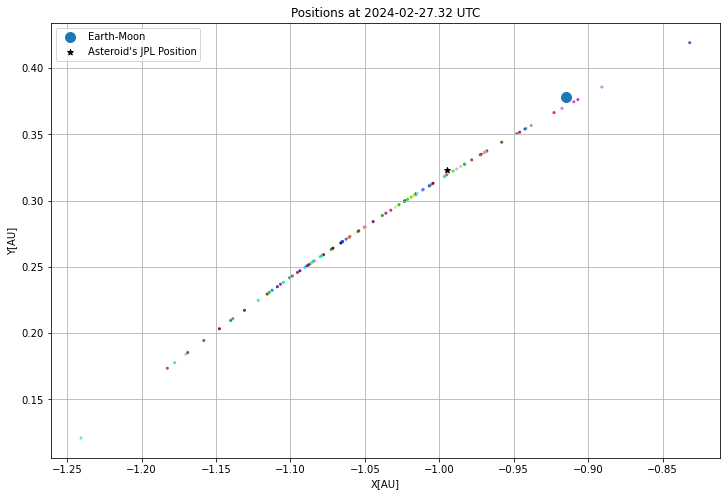

In [74]:
Ast = Asteroid('2021EU')
Ast.set_date('2024-02-27.32')
Ast.calculate_surrogates(Nsur=100)
Ast.plot()